# Training and Testing

This notebook is for building the regional models with the broadcasting layers. For Google Colab only.

![picture](https://facultyprofiles.hkust.edu.hk/profiles/images/P000002589.jpg)

## Set up the environment

### Import the packages

In [1]:
! pip install geopy
import torch
import torch.nn as nn
import torch.nn.functional as F

import os, sys
import numpy as np

### Training device

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device {device}...')

Using device cuda...


### Saving and loading files to/from different places

- **Temporary files** will be saved in the COLAB workspace directory
- **Models** and other files necessary for long-term use will be saved in the drive directory 

In [3]:
workspace_dir = '/content'
drive_dir = '/content/drive/Othercomputers/DESKTOP-P14JC7J/2130/code'
sys.path.append(drive_dir)

from data_utils import *

### Copy the processed data here

The processed data should be saved on the Google drive.

In [4]:
! mkdir data
! mkdir baseline-results
! cp ./drive/MyDrive/urop-paper2-data/* ./data
! cp ./drive/MyDrive/urop-paper2-baseline-results/* ./baseline-results

## Dataset
The dataset used for training and testing.

In [21]:
from data_utils import *
from data_utils.obs import ObsReader

from torch.utils.data import Dataset

from datetime import datetime, date, time, timedelta

class RegionalDataset(Dataset):
  def __init__(self, train, device, test_target_stations = None):
    super().__init__()
    self.period = 'train' if train else 'test'
    self.device = device
    self.first_date = eval(f'{self.period}_first_dt').date()
    self.last_date = eval(f'{self.period}_last_dt').date()

    self.obs_normalizing = load_dict(f'{data_dir}/obs_normalizing.pkl')
    self.wrf_normalizing = np.load(f'{data_dir}/wrf_normalizing.npz')
    self.wrf_normalizing = (self.wrf_normalizing['mean'], self.wrf_normalizing['std'])
    self.cmaq_normalizing = np.load(f'{data_dir}/cmaq_normalizing.npz')
    self.cmaq_normalizing = (self.cmaq_normalizing['mean'], self.cmaq_normalizing['std'])

    target_wrf_match = load_dict(f'{data_dir}/{self.period}_target_wrf_match.pkl')
    target_cmaq_match = load_dict(f'{data_dir}/{self.period}_target_cmaq_match.pkl')

    source_obs_data = load_dict(f'{data_dir}/{self.period}_source_data.pkl')
    target_obs_data = load_dict(f'{data_dir}/{self.period}_target_data.pkl')

    assert list(target_obs_data.keys()) == list(target_wrf_match.keys()) == list(target_cmaq_match.keys())

    self.source_obs_reader = ObsReader(source_obs_data)
    self.target_obs_reader = ObsReader(target_obs_data, test_target_stations if not train else None)

    target_wrf_data = np.load(f'{data_dir}/{self.period}_target_wrf_data.npy')
    target_cmaq_data = np.load(f'{data_dir}/{self.period}_target_cmaq_data.npy')
        
    if train or test_target_stations is None:
      self.target_wrf_data, self.target_cmaq_data = target_wrf_data, target_cmaq_data
    else:
      test_target_station_indices = np.array([list(target_obs_data.keys()).index(st) for st in test_target_stations])
      self.target_wrf_data = target_wrf_data[:, test_target_station_indices]
      self.target_cmaq_data = target_cmaq_data[:, test_target_station_indices]

    assert len(self) == self.target_wrf_data.shape[0] == self.target_cmaq_data.shape[0]

    self.source_loc = load_dict(f'{data_dir}/source_loc.pkl')
    
    target_loc = load_dict(f'{data_dir}/{self.period}_target_loc.pkl')
    if train or test_target_stations is None:
      self.target_loc = target_loc
    else:
      self.target_loc = {st: target_loc[st] for st in test_target_stations}

  def get_source_obs(self, day0):
    first_dt = datetime.combine(day0-timedelta(days = history_days), time(0))
    last_dt = datetime.combine(day0-timedelta(days = 1), time(23))
    source_obs = self.source_obs_reader(first_dt, last_dt)
    out = {}
    for st, df in source_obs.items():
      means, stds = np.array([self.obs_normalizing[sp][0] for sp in df.columns]), np.array([self.obs_normalizing[sp][1] for sp in df.columns])
      out[st] = torch.nan_to_num(torch.tensor(((df.values - means) / stds).T, dtype = torch.float, device = self.device))
    return out

  def get_target_obs(self, day0):
    means, stds = np.array([self.obs_normalizing[sp][0] for sp in target_species]), np.array([self.obs_normalizing[sp][1] for sp in target_species])
    first_dt = datetime.combine(day0, time(0))
    last_dt = datetime.combine(day0 + timedelta(days = horizon_days - 1), time(23))
    target_obs = self.target_obs_reader(first_dt, last_dt)
    return torch.tensor(np.array([((df.values - means)/stds).T for df in target_obs.values()]), dtype = torch.float, device = self.device)

  def __getitem__(self, index):
    day0 = self.first_date + timedelta(days = history_days + index)

    source_obs = self.get_source_obs(day0)
    target_wrf = torch.tensor((self.target_wrf_data[index] - self.wrf_normalizing[0][:, None])/self.wrf_normalizing[1][:, None], dtype = torch.float, device = self.device)
    target_cmaq = torch.tensor((self.target_cmaq_data[index] - self.cmaq_normalizing[0][:, None])/self.cmaq_normalizing[1][:, None], dtype = torch.float, device = self.device)
    target_wrf_cmaq = torch.cat([target_wrf, target_cmaq], dim = -2)

    target_obs = self.get_target_obs(day0)

    return source_obs, target_wrf_cmaq, target_obs

  def __len__(self):
    return (self.last_date - self.first_date).days - (history_days + horizon_days) + 2

  def get_dist(self):
    return torch.tensor(batch_dist(np.array(list(self.target_loc.values())), np.array(list(self.source_loc.values()))), dtype = torch.float, device = self.device)


def regional_dataset_collate_fn(batch):
  source_obs_out, target_wrf_cmaq_out, target_obs_out = [], [], []
  for source_obs, target_wrf_cmaq, target_obs in batch:
    source_obs_out.append(source_obs)
    target_wrf_cmaq_out.append(target_wrf_cmaq)
    target_obs_out.append(target_obs)
  return torch.utils.data._utils.collate.default_collate(source_obs_out), torch.stack(target_wrf_cmaq_out, axis = 1), torch.stack(target_obs_out, axis = 1)

In [22]:
! python -m data_utils.plot_stations

/usr/bin/python3: Error while finding module specification for 'data_utils.plot_stations' (ModuleNotFoundError: No module named 'data_utils')


## Training
### Hyperparameters
Hyperparameters for training the model and model configurations.

In [ ]:
num_epoch = 32
batch_size = 128
learning_rate, gamma, step_size = 1e-3, 0.9, 100
broadcasting = 'Broadcasting'

### Initialization
Build the models, optimizers and learning rate schedulers, and the dataset

In [ ]:
# the model, the optimizer and the scheduler
from model import Regional
regional_model = Regional({st: len(df.columns) for st, df in load_dict(f'{data_dir}/train_source_data.pkl').items()}, broadcasting = broadcasting).to(device)
optimizer = torch.optim.Adam(regional_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma = gamma, step_size = step_size)

In [ ]:
from torch.utils.data import DataLoader

# the training set and the distance used
training_set = RegionalDataset(train = True, device = device)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, collate_fn=regional_dataset_collate_fn)
training_dist = training_set.get_dist()

# the validation set and the distance used
validation_set = RegionalDataset(train = False, device = device)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, collate_fn=regional_dataset_collate_fn)
validation_dist = validation_set.get_dist() 

### Training loop

In [ ]:
for i in range(num_epoch):
  regional_model.train()
  train_epoch_loss = 0.0
  for source_obs, target_wrf_cmaq, target_obs in training_loader:
    optimizer.zero_grad()
    out = regional_model(source_obs, target_wrf_cmaq, training_dist)
    mask = ~torch.isnan(target_obs)
    loss = torch.abs(out[mask] - target_obs[mask]).mean()
    with torch.no_grad():
      train_epoch_loss += loss.item() * target_obs.shape[1] / len(training_set)
    loss.backward()
    optimizer.step()
    scheduler.step()
  

  if hasattr(regional_model.broadcasting, 'distance_decay'):
    with torch.no_grad():
      regional_model.broadcasting.distance_decay.data.clamp_(0.0)

  valid_epoch_loss = 0.0
  regional_model.eval()
  with torch.no_grad():
    for source_obs, target_wrf_cmaq, target_obs in validation_loader:
      out = regional_model(source_obs, target_wrf_cmaq, validation_dist)
      mask = ~torch.isnan(target_obs)
      loss = torch.abs(out[mask] - target_obs[mask]).mean()
      valid_epoch_loss += loss.item() * target_obs.shape[1] / len(validation_set)

  print(f'Epoch {i}, training loss {train_epoch_loss:.3g}, validation loss {valid_epoch_loss:.3g}...')
  if train_epoch_loss < valid_epoch_loss:
    break

### Save the trained model

In [ ]:
import json
model_dir = f'{drive_dir}/models/{broadcasting}_model'
os.makedirs(model_dir, exist_ok = True)
torch.save(regional_model.state_dict(), f'{model_dir}/state_dict')
torch.save(optimizer.state_dict(), f'{model_dir}/optimizer_state_dict')
torch.save(scheduler.state_dict(), f'{model_dir}/scheduler_state_dict')
with open (f'{model_dir}/training_config.json', 'w') as f:
  json.dump({
    'num_epoch': num_epoch, 
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'step_size': step_size
  }, f)

## Testing
Test on the testing target stations that are neither training target stations nor source stations, report the results on multiple metrics.


### Load the trained model


In [23]:
from model import Regional
broadcasting = 'Broadcasting'
model_dir = f'{drive_dir}/models/{broadcasting}_model'
regional_model = Regional({st: len(df.columns) for st, df in load_dict(f'{data_dir}/train_source_data.pkl').items()}, broadcasting = broadcasting).to(device)
regional_model.load_state_dict(torch.load(f'{model_dir}/state_dict'))

<All keys matched successfully>

### Load the testing data

In [24]:
# Only the testing target stations that are neither training target stations nor source stations
source_stations = set(load_dict(f'{data_dir}/source_loc.pkl').keys())
train_target_stations = set(load_dict(f'{data_dir}/train_target_loc.pkl').keys())
test_target_stations = set(load_dict(f'{data_dir}/test_target_loc.pkl').keys())

test_target_stations = list(test_target_stations - train_target_stations - source_stations)

In [25]:
# denormalize the output
obs_normalizing = load_dict(f'{data_dir}/obs_normalizing.pkl')
means, stds = np.array([obs_normalizing[sp][0] for sp in target_species]), np.array([obs_normalizing[sp][1] for sp in target_species])

In [26]:
# the testing set
test_batch_size = 128

testing_set = RegionalDataset(train = False, device = device, test_target_stations = test_target_stations)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=test_batch_size, collate_fn=regional_dataset_collate_fn)
test_dist = testing_set.get_dist()

In [27]:
regional_model.eval()
assert not regional_model.training

In [28]:
pred, y = [], []
with torch.no_grad():
  testing_loss = 0.0
  for source_obs, target_wrf_cmaq, target_obs in testing_loader:
    pred.append(regional_model.predict(source_obs, target_wrf_cmaq, test_dist, (means, stds)))
    y.append(target_obs.cpu().numpy() * stds[:, None] + means[:, None])
pred, y = np.concatenate(pred, axis = 1), np.concatenate(y, axis = 1)
pred_by_day, y_by_day = pred.reshape(*pred.shape[:-1], 2, 24), y.reshape(*y.shape[:-1], 2, 24)

### Load the baseline data
- CMAQ prediction
- Spatial correction via multiple different interpolation methods

In [29]:
# CMAQ
cmaq_pred = load_dict(f'baseline-results/cmaq_pred.pkl')
cmaq_pred = np.maximum(np.stack([cmaq_pred[st] for st in test_target_stations]), 0)
cmaq_pred_by_day = cmaq_pred.reshape(*cmaq_pred.shape[:-1], 2, 24)

In [30]:
! ls baseline-results

cmaq_pred.pkl	      source_sc_IDW_pred.pkl	  source_sc_NN_pred.pkl
source_cmaq_pred.pkl  source_sc_Kriging_pred.pkl


In [31]:
# NN
nn_pred = load_dict(f'baseline-results/source_sc_NN_pred.pkl')
nn_pred = np.maximum(np.stack([nn_pred[st] for st in test_target_stations]), 0)
nn_pred_by_day = nn_pred.reshape(*nn_pred.shape[:-1], 2, 24)

In [32]:
# IDW
idw_pred = load_dict(f'baseline-results/source_sc_IDW_pred.pkl')
idw_pred = np.maximum(np.stack([idw_pred[st] for st in test_target_stations]), 0)
idw_pred_by_day = idw_pred.reshape(*idw_pred.shape[:-1], 2, 24)

In [33]:
# Kriging
kriging_pred = load_dict(f'baseline-results/source_sc_Kriging_pred.pkl')
kriging_pred = np.maximum(np.stack([kriging_pred[st] for st in test_target_stations]), 0)
kriging_pred_by_day = kriging_pred.reshape(*kriging_pred.shape[:-1], 2, 24)

In [34]:
arrs_by_day = [cmaq_pred_by_day, nn_pred_by_day, idw_pred_by_day, kriging_pred_by_day, pred_by_day]
arr_names = ['CMAQ', 'SC (NN)', 'SC (IDW)', 'SC (Kriging)', 'Broadcasting']

### The evaluation metrics:
- `MBE` is used to evaluate the bias issue.
- Others will be presented in the publication.

In [35]:
def MBE(pred, y, axis = 0):
  return np.nanmean(pred - y, axis = axis) / (np.nanmean(y, axis = axis))

def MAE(pred, y, axis = 0):
  return np.nanmean(np.abs(pred - y), axis = axis)

def RMSE(pred, y, axis = 0):
  return np.sqrt(np.nanmean((pred - y)**2, axis = axis))

def SMAPE(pred, y, axis = 0):
  return 200 * np.nanmean(np.abs(pred - y) / (np.abs(pred) + np.abs(y)), axis = axis)

def R(pred, y, axis = 0):
  mask = ~np.isnan(y)
  n = mask.sum(axis = axis, keepdims = True)
  pred_mean = np.sum(pred * mask, axis = axis, keepdims = True) / n
  y_mean = np.nanmean(y, axis = axis, keepdims = True)
  r = np.nansum((pred - pred_mean) * (y - y_mean), axis = axis)/ np.sqrt(np.sum(mask * (pred - pred_mean)**2, axis = axis) * np.nansum((y - y_mean)**2, axis = axis))
  return r

In [36]:
metrics = [MAE, RMSE, SMAPE, R]

### Print the evaluation results

In [37]:
import pandas as pd
results = {(sp, j): pd.DataFrame(columns = [MBE.__name__]+[m.__name__ for m in metrics]) for sp in target_species for j in range(horizon_days)}

for m in [MBE]+metrics:
  cmaq_arr = m(cmaq_pred_by_day, y_by_day, (0, 1, 4))
  nn_arr = m(nn_pred_by_day, y_by_day, (0, 1, 4))
  idw_arr = m(idw_pred_by_day, y_by_day, (0, 1, 4))
  kriging_arr = m(kriging_pred_by_day, y_by_day, (0, 1, 4))
  broadcasting_arr = m(pred_by_day, y_by_day, (0, 1, 4))
  
  for i, sp in enumerate(target_species):
    for j in range(horizon_days):
      results[sp, j].loc['CMAQ', m.__name__] = cmaq_arr[i, j]
      results[sp, j].loc['NN', m.__name__] = nn_arr[i, j]
      results[sp, j].loc['IDW', m.__name__] = idw_arr[i, j]
      results[sp, j].loc['Kriging', m.__name__] = kriging_arr[i, j]
      results[sp, j].loc[broadcasting, m.__name__] = broadcasting_arr[i, j] 

In [38]:
results['FSPMC', 0]

,MBE,MAE,RMSE,SMAPE,R
CMAQ,0.367759,12.62485,21.855939,59.138722,0.555296
NN,0.285529,11.599979,18.639697,62.820855,0.497923
IDW,0.300734,10.56807,17.718181,53.777048,0.51461
Kriging,0.203955,10.050271,16.508678,55.807458,0.504883
Broadcasting,0.01626,6.455465,9.157114,41.247411,0.738549


In [39]:
results['FSPMC', 1]

,MBE,MAE,RMSE,SMAPE,R
CMAQ,0.395993,13.008929,22.383502,59.826695,0.548784
NN,0.350339,12.561622,19.512109,65.251965,0.469293
IDW,0.374219,11.531087,18.762417,56.885472,0.492302
Kriging,0.268948,10.925946,17.219645,58.754419,0.47783
Broadcasting,0.097252,7.237325,9.758955,45.069032,0.704689


In [40]:
results['O3', 0]

,MBE,MAE,RMSE,SMAPE,R
CMAQ,0.334648,16.098667,21.062601,60.049082,0.613268
NN,-0.065381,12.381466,16.674949,58.141351,0.663715
IDW,-0.050399,11.713511,15.88709,53.771363,0.683579
Kriging,-0.050739,11.533438,15.61569,54.163077,0.699402
Broadcasting,-0.01813,10.649495,14.471837,46.002566,0.741144


In [41]:
results['O3', 1]

,MBE,MAE,RMSE,SMAPE,R
CMAQ,0.330544,16.328002,21.220851,61.078863,0.600618
NN,-0.068699,12.658845,17.111046,58.741531,0.640526
IDW,-0.048654,12.105106,16.368506,54.995285,0.659417
Kriging,-0.052019,11.875554,16.096089,55.111547,0.676692
Broadcasting,0.017399,11.185888,15.216287,47.529905,0.710543


### Put them in quartiles


In [56]:
#### classify by day
quartiles = np.stack([np.nanquantile(y_by_day.mean(axis = -1), p, axis = (0, 1)) for p in [0.25, 0.5, 0.75]], axis = -1)
print(quartiles.mean(axis = 1))
classifications = np.zeros(y_by_day.shape[:-1], dtype = int)

mask_q1 = np.nanmean(y_by_day, axis = -1) < quartiles[:, :, 0]
mask_q2 = np.logical_and(np.nanmean(y_by_day, axis = -1) < quartiles[:, :, 1], ~mask_q1)
mask_q3 = np.all([np.nanmean(y_by_day, axis = -1) < quartiles[:, :, 2], ~mask_q1, ~mask_q2], axis = 0)
mask_q4 = np.all([~np.isnan(np.nanmean(y_by_day, axis = -1)), ~mask_q1, ~mask_q2, ~mask_q3], axis = 0)
masks = [mask_q1, mask_q2, mask_q3, mask_q4]

[[ 9.83333352 15.67680101 24.09907085]
 [17.44381354 25.5125656  36.88779582]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


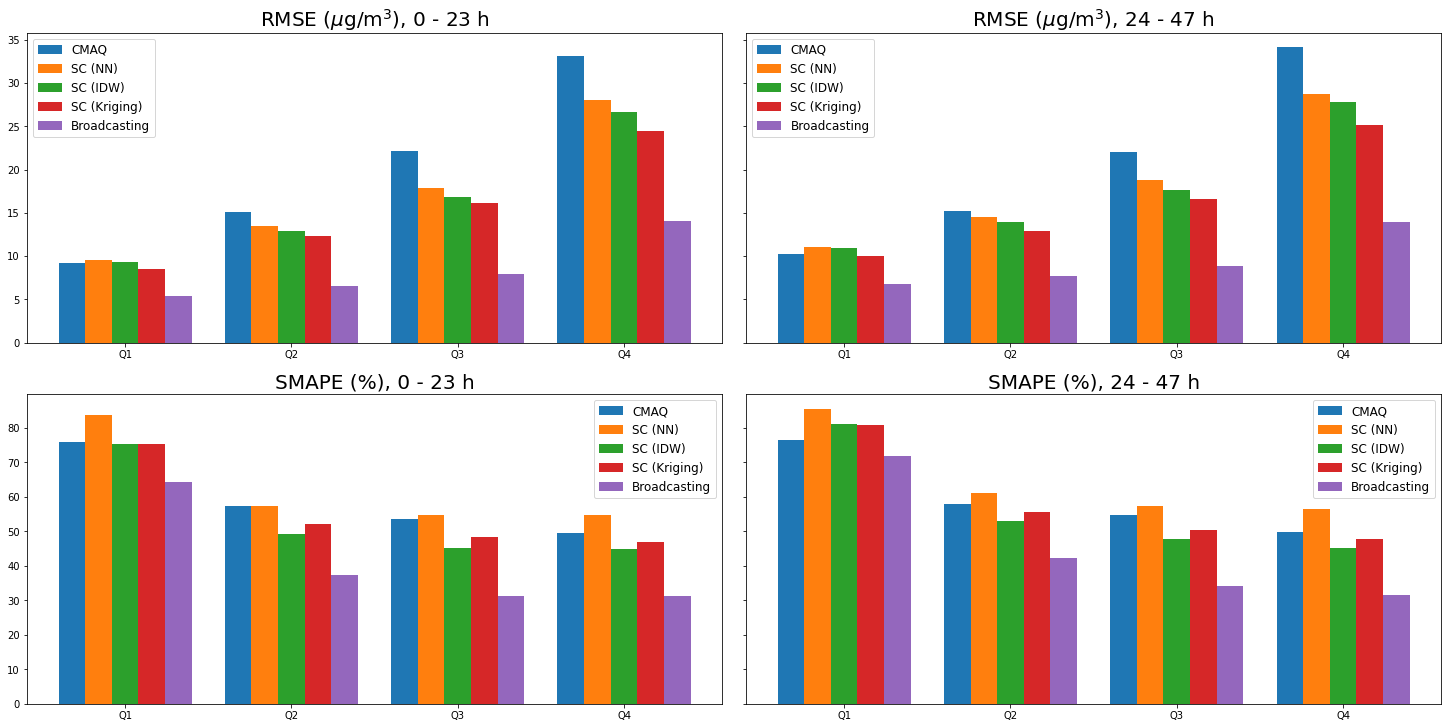

In [43]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize = (20, 10), constrained_layout = True, sharey = 'row')
for i, (m, u) in enumerate(zip([RMSE, SMAPE], ['$\mu$g/m$^3$', '%'])):
  for j in range(horizon_days):
    y_arr_by_q = [y_by_day[:, :, 0, j, :][mask[:, :, 0, j]] for mask in masks]
    arrs_by_q = [[arr[:, :, 0, j, :][mask[:, :, 0, j]] for arr in arrs_by_day] for mask in masks]
    metric_values = []
    for q_y_arr, q_arrs in zip(y_arr_by_q, arrs_by_q):
      metric_values.append([m(q_y_arr, q_arr, axis = (0, 1)) for q_arr in q_arrs])
    metric_values = np.array(metric_values)
    axes[i, j].set_title(f'{m.__name__} ({u}), {24 * j} - {24 * j + 23} h', fontsize = 20)

    total_width, n = 0.8, 5
    width = total_width / n
    x = np.arange(4)
    x = x - (total_width - width) / 2

    for k, (mv, an) in enumerate(zip(metric_values.T, arr_names)):
      axes[i, j].bar(x + k * width, mv,  width=width, label=an)
    axes[i, j].set_xticks(np.arange(4))
    axes[i, j].set_xticklabels([f'Q{i+1}' for i in range(4)])
    axes[i, j].legend(fontsize = 12)
    
    
    
    

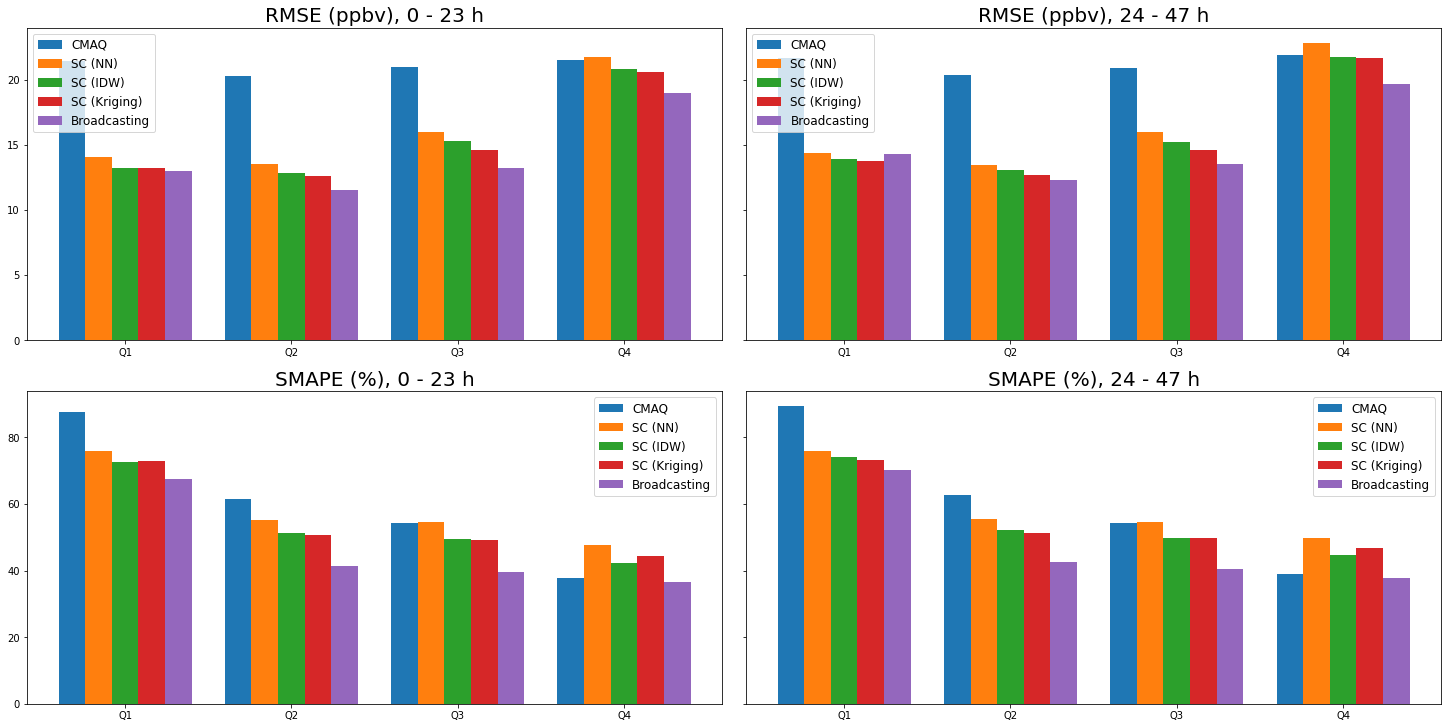

In [44]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize = (20, 10), constrained_layout = True, sharey = 'row')
for i, (m, u) in enumerate(zip([RMSE, SMAPE], ['ppbv', '%'])):
  for j in range(horizon_days):
    y_arr_by_q = [y_by_day[:, :, 1, j, :][mask[:, :, 1, j]] for mask in masks]
    arrs_by_q = [[arr[:, :, 1, j, :][mask[:, :, 1, j]] for arr in arrs_by_day] for mask in masks]
    metric_values = []
    for q_y_arr, q_arrs in zip(y_arr_by_q, arrs_by_q):
      metric_values.append([m(q_y_arr, q_arr, axis = (0, 1)) for q_arr in q_arrs])
    metric_values = np.array(metric_values)
    axes[i, j].set_title(f'{m.__name__} ({u}), {24 * j} - {24 * j + 23} h', fontsize = 20)

    total_width, n = 0.8, 5
    width = total_width / n
    x = np.arange(4)
    x = x - (total_width - width) / 2

    for k, (mv, an) in enumerate(zip(metric_values.T, arr_names)):
      axes[i, j].bar(x + k * width, mv,  width=width, label=an)
    axes[i, j].set_xticks(np.arange(4))
    axes[i, j].set_xticklabels([f'Q{i+1}' for i in range(4)])
    axes[i, j].legend(fontsize = 12)

In [46]:
_ = torch.zeros([1000, 1000, 1000], device = 'cuda')

### Plot the performance for each time step

In [47]:
import matplotlib.pyplot as plt
cmaq_metric_values_by_hour = {}
nn_metric_values_by_hour = {}
idw_metric_values_by_hour = {}
kriging_metric_values_by_hour = {}
metric_values_by_hour = {}

for m in metrics:
  cmaq_arr = m(cmaq_pred, y, (0, 1))
  nn_arr = m(nn_pred, y, (0, 1))
  idw_arr = m(idw_pred, y, (0, 1))
  kriging_arr = m(kriging_pred, y, (0, 1))
  broadcasting_arr = m(pred, y, (0, 1))
  for i, sp in enumerate(target_species):
    cmaq_metric_values_by_hour[sp, m.__name__] = cmaq_arr[i]
    nn_metric_values_by_hour[sp, m.__name__] = nn_arr[i]
    idw_metric_values_by_hour[sp, m.__name__] = idw_arr[i]
    kriging_metric_values_by_hour[sp, m.__name__] = kriging_arr[i]
    metric_values_by_hour[sp, m.__name__] = broadcasting_arr[i]

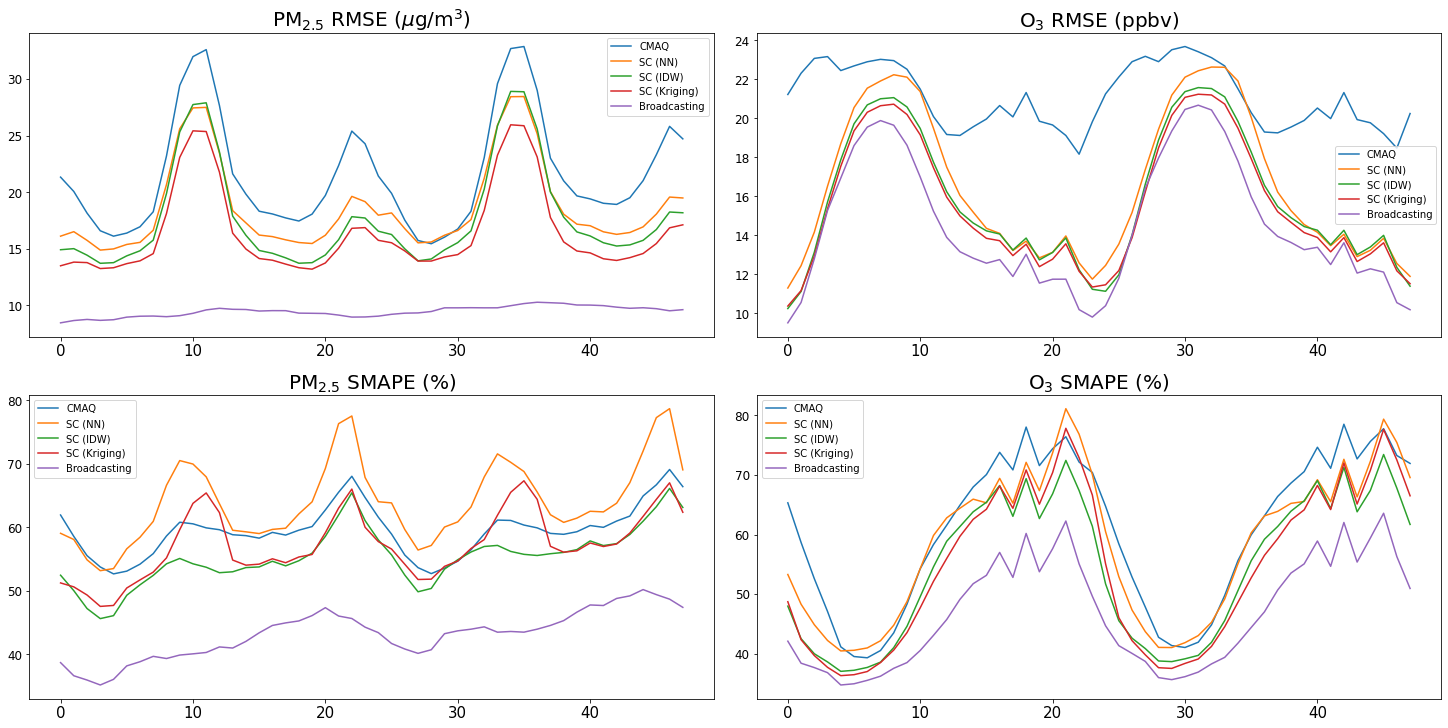

In [48]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10), constrained_layout = True)
for i, (sp, disp_name, unit) in enumerate(zip(target_species, ['PM$_{2.5}$', 'O$_3$'], ['$\mu$g/m$^3$', 'ppbv'])):
  units = [unit, '%']
  for ax, m, u in zip(axes[:, i], [RMSE, SMAPE], units):
    ax.set_title(f'{disp_name} {m.__name__}' + (f' ({u})' if u is not None else ''), fontsize = 20)
    ax.xaxis.set_tick_params(labelsize = 15)
    ax.yaxis.set_tick_params(labelsize = 12)
    ax.plot(cmaq_metric_values_by_hour[sp, m.__name__], label = 'CMAQ')
    ax.plot(nn_metric_values_by_hour[sp, m.__name__], label = 'SC (NN)')
    ax.plot(idw_metric_values_by_hour[sp, m.__name__], label = 'SC (IDW)')
    ax.plot(kriging_metric_values_by_hour[sp, m.__name__], label = 'SC (Kriging)')
    ax.plot(metric_values_by_hour[sp, m.__name__], label = broadcasting)
    ax.legend(fontsize = 10)

### Plot the time series by day for each test stations

In [49]:
test_target_loc = load_dict(f'{data_dir}/test_target_loc.pkl')
os.makedirs(f'{drive_dir}/plots/by_station', exist_ok = True)

arr_names = ['y', 'cmaq_pred', 'nn_pred', 'idw_pred', 'kriging_pred', 'pred']
labels = ['Observation', 'CMAQ', 'SC (NN)', 'SC (IDW)', 'SC (Kriging)', 'Broadcasting']

In [50]:
mask = ~np.isnan(y_by_day) 
y_regional_avg = np.nanmean(y_by_day, axis = (0, 4))

for an in arr_names:
  globals ()[f'{an}_regional_avg'] = eval(f'{an}_by_day')
  globals ()[f'{an}_regional_avg'][~mask] = np.nan
  globals ()[f'{an}_regional_avg'] = np.nanmean(eval(f'{an}_regional_avg'), axis = (0, 4))

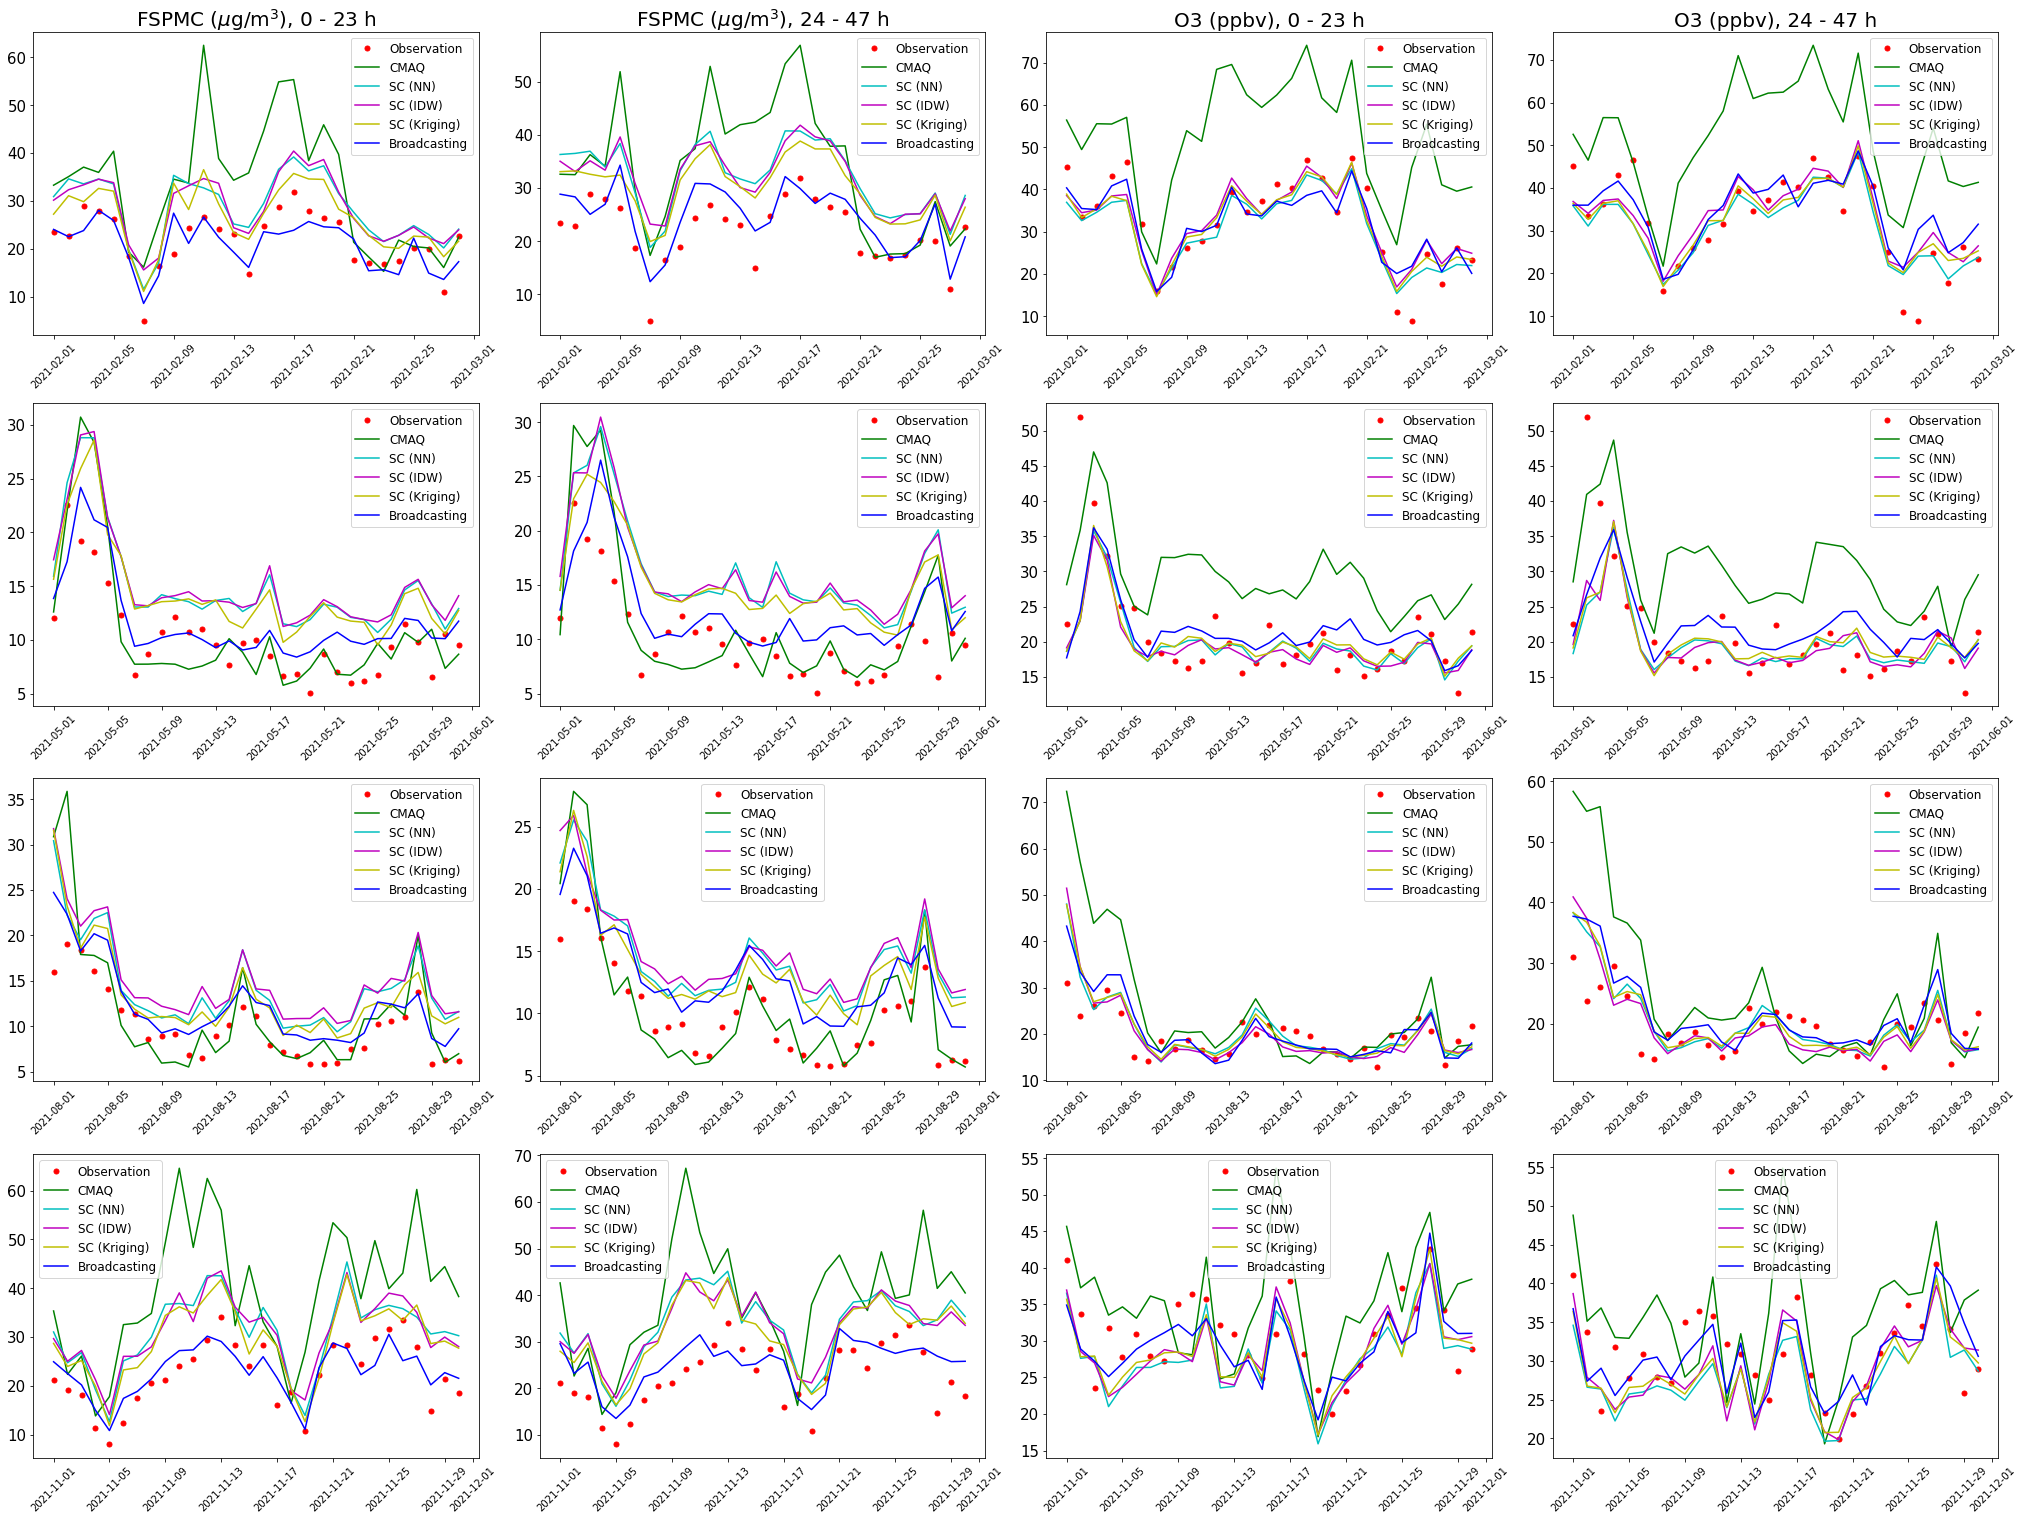

In [53]:
from datetime import date, time, datetime, timedelta
plotted_months = [2, 5, 8, 11]
fig, axes = plt.subplots(len(plotted_months), 4, figsize = (28, 21), constrained_layout = True)

for i, mth in enumerate(plotted_months):
  indices = [slice((date(2021, mth, 1) - test_first_dt.date()).days, (date(2021, mth+1, 1) - test_first_dt.date()).days), slice((date(2021, mth, 1) - test_first_dt.date()).days - 1, (date(2021, mth+1, 1) - test_first_dt.date()).days - 1)]
  time_axis = [date(2021, mth, 1) + timedelta(days = i) for i in range((date(2021, mth+1, 1) - date(2021, mth, 1)).days)]
  
  mth_axes = axes[i].reshape(len(target_species), horizon_days)
  for j, (sp, u) in enumerate(zip(target_species, ['$\mu$g/m$^3$', 'ppbv'])):
    for k, idx in enumerate(indices):
      if i == 0:
        mth_axes[j, k].annotate(f'{sp} ({u}), {24 * k} - {23 + 24 * k} h', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontsize = 20)
      # mth_axes[j, k].set_title(f'{sp} ({u}), day {j}', fontsize = 30)
      mth_axes[j, k].plot(time_axis, y_regional_avg[idx, j, k], 'ro', label = 'Observation', markersize = 5)
      for an, s, l in zip(arr_names[1:], 'gcmyb', labels[1:]):
        mth_axes[j, k].plot(time_axis, eval(f'{an}_regional_avg')[idx, j, k], s, label = l)
      
      mth_axes[j, k].legend(fontsize = 12)
      mth_axes[j, k].xaxis.set_tick_params(labelsize = 10, rotation=45)
      mth_axes[j, k].yaxis.set_tick_params(labelsize = 15)